# Applying SCRIPT Method with one minute time interval for new application

Developed by Siobhan Powell, 2021. 

In [1]:
# import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import time

## Inspect Profiles

In [4]:
date = '20240208'

In [5]:
control1 = 'MEF_weekday_2028'
control2 = 'AEF_weekday_2028'
control3 = ''
location = 'work'
reg = 'nonreg'
uncontrolled = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_input_data_uncontrolled_'+location+'_'+date+'.npy')
controlled1 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_output_data_'+control1+'_'+location+'_'+date+'_'+reg+'.npy')
controlled2 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_output_data_'+control2+'_'+location+'_'+date+'_'+reg+'.npy')

controlled3 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_mrmef_20240208/control_output_data_MRMEF_delta10000_startyear2028_5yearsahead_weekday_work_20240208_nonreg.npy')

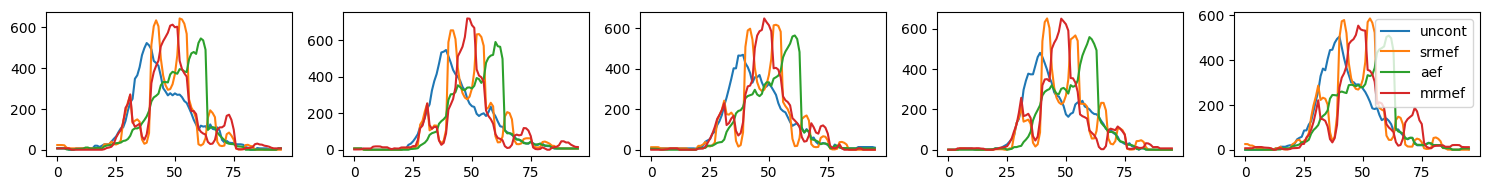

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
for i in range(5):
    axes[i].plot(uncontrolled[i, :], label='uncont')
    axes[i].plot(controlled1[i, :], label='srmef')
    axes[i].plot(controlled2[i, :], label='aef')
    axes[i].plot(controlled3[i, :], label='mrmef')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
control1 = 'MEF_weekday_2023'
control2 = 'AEF_weekday_2023'
location = 'home'
reg = 'nonreg'
uncontrolled = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_input_data_uncontrolled_'+location+'_'+date+'.npy')
controlled1 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_output_data_'+control1+'_'+location+'_'+date+'_'+reg+'.npy')
controlled2 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/control_output_data_'+control2+'_'+location+'_'+date+'_'+reg+'.npy')
controlled3 = np.load('/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_mrmef_20240208/control_output_data_MRMEF_delta10000_startyear2023_5yearsahead_weekday_work_20240208_nonreg.npy')


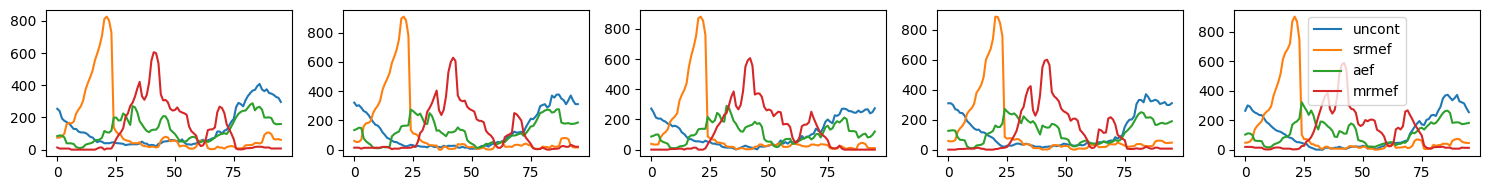

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
for i in range(5):
    axes[i].plot(uncontrolled[i, :], label='uncont')
    axes[i].plot(controlled1[i, :], label='srmef')
    axes[i].plot(controlled2[i, :], label='aef')
    axes[i].plot(controlled3[i, :], label='mrmef')
plt.legend()
plt.tight_layout()
plt.show()

## Fit models

and report the results / error metric

In [24]:
from sklearn import metrics
from sklearn.preprocessing import normalize
import sklearn
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import pickle

In [25]:
def normalize_profiles(uncontrolled_profiles, controlled_profiles, return_norms=False):
    
    uncont_norm, norms_out = normalize(uncontrolled_profiles, norm='max', axis=1, return_norm=True)
    cont_norm = np.zeros(np.shape(controlled_profiles))
    for i in range(np.shape(controlled_profiles)[0]):
        cont_norm[i, :] = controlled_profiles[i, :] / norms_out[i]
        
    if return_norms:
        return uncont_norm, cont_norm, norms_out
    else:
        return uncont_norm, cont_norm

def max_absolute_error(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return diff
score = metrics.make_scorer(max_absolute_error, greater_is_better=False)

def aggregate(uncontrolled_profiles, controlled_profiles, shuffle=False, k=10):
    
    if shuffle:
        length = np.shape(uncontrolled_profiles)[0]
        new_inds = np.random.choice(range(length), length, replace=False)
        uncontrolled_profiles = uncontrolled_profiles[new_inds, :]
        controlled_profiles = controlled_profiles[new_inds, :]

    new_uncontrolled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    new_controlled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    for i in range(int(np.shape(uncontrolled_profiles)[0]/k)):
        for j in range(k):
            new_uncontrolled_profiles[i, :] += uncontrolled_profiles[k*i + j, :]
            new_controlled_profiles[i, :] += controlled_profiles[k*i + j, :]
            
    return uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles

def agg_fit_test(uncontrolled_profiles, controlled_profiles, return_all=False, agg=False):
    
    if agg:
        uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles = aggregate(uncontrolled_profiles, 
                                                                                                                   controlled_profiles, shuffle=True, k=10)
    else:
        new_uncontrolled_profiles = np.copy(uncontrolled_profiles)
        new_controlled_profiles = np.copy(controlled_profiles)
    
    uncont_norm, cont_norm = normalize_profiles(new_uncontrolled_profiles, new_controlled_profiles)
    X_train, X_test, y_train, y_test = train_test_split(uncont_norm, cont_norm, test_size=0.2, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=1/8, random_state=42)

    param_grid = {'alpha':np.linspace(0, 2, 50)}
    clf_grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5) 
    clf_grid.fit(X_train, y_train)
    new_clf = clf_grid.best_estimator_
#     new_clf = LinearRegression(fit_intercept=True)
    new_clf.fit(X_train, y_train)

    mean_error = metrics.mean_squared_error(y_dev, new_clf.predict(X_dev))
    max_error =  max_absolute_error(y_dev, new_clf.predict(X_dev))
    rmse = np.sqrt(mean_error)
    print('Mean squared error:', mean_error)
    print('RMSE: ', rmse)
    print('Max abs error:', max_error)
    if return_all:
        return new_clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse
    else:
        return new_clf

### Test fitting

In [27]:
control1 = 'MEF_weekday_2023'
control2 = 'AEF_weekday_2023'
location = 'home'
reg = 'nonreg'
date = '20240208'

folder = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_'+date+'/'
uncontrolled = np.load(folder+'control_input_data_uncontrolled_'+location+'_'+date+'.npy')
controlled1 = np.load(folder+'control_output_data_'+control1+'_'+location+'_'+date+'_'+reg+'.npy')
controlled2 = np.load(folder+'control_output_data_'+control2+'_'+location+'_'+date+'_'+reg+'.npy')



Mean squared error: 0.00226973179424106
RMSE:  0.04764170226011094
Max abs error: 0.28501529361746236


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

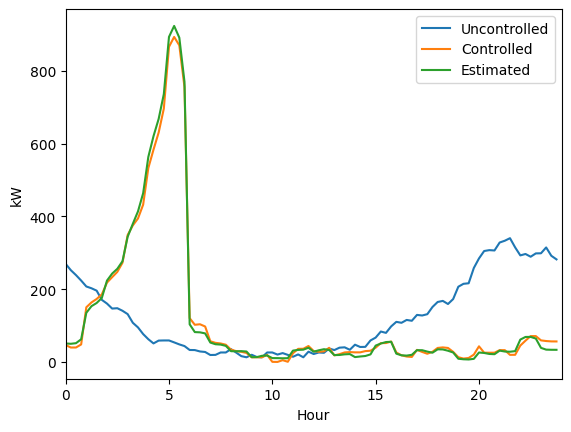

In [30]:
y = np.copy(controlled1)
X = np.copy(uncontrolled)
clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse = agg_fit_test(X, y, return_all=True)
idx = 10

Xnorm, ynorm, norms = normalize_profiles(X, y, return_norms=True)
ypred_norm = clf.predict(Xnorm[idx, :].reshape(1, -1))
ypred = norms[idx] * ypred_norm
plt.figure()
plt.plot((1/4)*np.arange(0, 96), X[idx, :])
plt.plot((1/4)*np.arange(0, 96), y[idx, :])
plt.plot((1/4)*np.arange(0, 96), ypred.ravel())
# plt.plot((1/60)*np.arange(0, 1440), X[idx, :])
# plt.plot((1/60)*np.arange(0, 1440), y[idx, :])
# plt.plot((1/60)*np.arange(0, 1440), ypred.ravel())
plt.legend(labels=['Uncontrolled', 'Controlled', 'Estimated'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.show()

# Run and save all

In [33]:
save_date = '20240208'
folder_aefmef = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_20240208/'
control_cases = [name + '_' + weekday + '_' + year for name in ['AEF', 'MEF'] for weekday in ['weekday', 'weekend'] for year in ['2023', '2028', '2033']]
fitting_results = pd.DataFrame(columns=[location+'_'+key2+'_'+reg for location in ['home', 'work'] for key2 in control_cases for reg in ['nonreg']], index=['mean_error', 'max_error', 'rmse'])
for key1 in ['home', 'work']: 
    for control in control_cases:
        for reg in ['nonreg']:#, 'reg10']:
            print('--'*5, control, reg, '--'*5)
            y = np.load(folder_aefmef + 'control_output_data_'+control+'_'+key1+'_'+date+'_'+reg+'.npy')
            X = np.load(folder_aefmef + 'control_input_data_uncontrolled_'+key1+'_'+date+'.npy')
            clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse = agg_fit_test(X, y, return_all=True)
            fitting_results.loc['mean_error', key1+'_'+control+'_'+reg] = mean_error
            fitting_results.loc['rmse', key1+'_'+control+'_'+reg] = rmse
            fitting_results.loc['max_error', key1+'_'+control+'_'+reg] = max_error
            pickle.dump(clf, open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+key1+'_'+control+'_'+reg+'_'+save_date+'.p', "wb"))
fitting_results.to_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_'+save_date+'.csv')
                              

---------- AEF_weekday_2023 nonreg ----------
Mean squared error: 0.0028572632738334976
RMSE:  0.05345337476561698
Max abs error: 0.26750833715246913
---------- AEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.003068808211588867
RMSE:  0.055396824923355195
Max abs error: 0.2603298795053296
---------- AEF_weekday_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.0030361028092169115
RMSE:  0.05510084218246498
Max abs error: 0.2593405470876108
---------- AEF_weekend_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.0029184528810728715
RMSE:  0.05402270708760226
Max abs error: 0.2618013733161947
---------- AEF_weekend_2028 nonreg ----------
Mean squared error: 0.0027963013025545714
RMSE:  0.05288006526617163
Max abs error: 0.22041255467925935
---------- AEF_weekend_2033 nonreg ----------
Mean squared error: 0.002763776348966851
RMSE:  0.05257163064778237
Max abs error: 0.21707353604049173
---------- MEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.00226973179424106
RMSE:  0.04764170226011094
Max abs error: 0.28501529361746236
---------- MEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.0027106280021528075
RMSE:  0.052063691783745106
Max abs error: 0.3024485478244152
---------- MEF_weekday_2033 nonreg ----------
Mean squared error: 0.0015096662362177604
RMSE:  0.03885442363769871
Max abs error: 0.19020021762094474
---------- MEF_weekend_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.002323513274759875
RMSE:  0.04820283471705658
Max abs error: 0.2696847782523464
---------- MEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.0026096642118513154
RMSE:  0.05108487263223151
Max abs error: 0.2609601576103806
---------- MEF_weekend_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25635e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.63955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.85118e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Mean squared error: 0.002350683622041118
RMSE:  0.04848384908442313
Max abs error: 0.30592062523238184
---------- AEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0008012708851382636
RMSE:  0.028306728619504295
Max abs error: 0.1758081887240448
---------- AEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0010330345269884743
RMSE:  0.03214085448441709
Max abs error: 0.20880765802116485
---------- AEF_weekday_2033 nonreg ----------
Mean squared error: 0.0010648453491890388
RMSE:  0.03263196820893644
Max abs error: 0.20767509121442185
---------- AEF_weekend_2023 nonreg ----------
Mean squared error: 0.0008076335497626151
RMSE:  0.028418894238914628
Max abs error: 0.18400652124500416
---------- AEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0010256412468061407
RMSE:  0.032025634213956496
Max abs error: 0.20814202224329859
---------- AEF_weekend_2033 nonreg ----------
Mean squared error: 0.0010394482510520248
RMSE:  0.03224047535400222
Max abs error: 0.20817757712794127
---------- MEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0008318805562097534
RMSE:  0.02884233964521175
Max abs error: 0.11874281009138299
---------- MEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.000805765649067123
RMSE:  0.028386011503328944
Max abs error: 0.1516559777769768
---------- MEF_weekday_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0012329326365903908
RMSE:  0.03511314051164308
Max abs error: 0.13958575861775752
---------- MEF_weekend_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0010867859534006165
RMSE:  0.032966436771368186
Max abs error: 0.20363787910607956
---------- MEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0014085868703941698
RMSE:  0.03753114533816108
Max abs error: 0.17108187556934917
---------- MEF_weekend_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.11042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0010759807064577604
RMSE:  0.032802144845387175
Max abs error: 0.24710737539061012


In [35]:
save_date = '20240208'
folder_mrmef = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_mrmef_'+date+'/'
control_cases = ['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_'+weekday for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033'] for weekday in ['weekday', 'weekend']]
fitting_results = pd.DataFrame(columns=[location+'_'+key2+'_'+reg for location in ['home', 'work'] for key2 in control_cases for reg in ['nonreg']], index=['mean_error', 'max_error', 'rmse'])
for key1 in ['home', 'work']: 
    for control in control_cases:
        for reg in ['nonreg']:
            print('--'*5, control, reg, '--'*5)
            y = np.load(folder_mrmef + 'control_output_data_'+control+'_'+key1+'_'+date+'_'+reg+'.npy')
            X = np.load(folder_mrmef + 'control_input_data_uncontrolled_'+key1+'_'+date+'.npy')
            clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse = agg_fit_test(X, y, return_all=True)
            fitting_results.loc['mean_error', key1+'_'+control+'_'+reg] = mean_error
            fitting_results.loc['rmse', key1+'_'+control+'_'+reg] = rmse
            fitting_results.loc['max_error', key1+'_'+control+'_'+reg] = max_error
            pickle.dump(clf, open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+key1+'_'+control+'_'+reg+'_'+save_date+'.p', "wb"))
fitting_results.to_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_mrmef_'+save_date+'.csv')
                              

---------- MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.005909770124429089
RMSE:  0.07687502926457387
Max abs error: 0.4733018532550666
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0038386962874471004
RMSE:  0.06195721336089205
Max abs error: 0.36024171754995615
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg ----------
Mean squared error: 0.005810778891217845
RMSE:  0.0762284650981367
Max abs error: 0.4753422770577762
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0029272474629373608
RMSE:  0.05410404294447284
Max abs error: 0.312299059404221
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.00389647167099579
RMSE:  0.06242172435134895
Max abs error: 0.39150147433603966
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.004833760155784441
RMSE:  0.06952524833313752
Max abs error: 0.3621601759762785
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.004932031043381901
RMSE:  0.07022842048189537
Max abs error: 0.416661413665111
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003734895217297791
RMSE:  0.06111378909295177
Max abs error: 0.3042195216443977
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg ----------
Mean squared error: 0.00524960947590155
RMSE:  0.07245418880852611
Max abs error: 0.46671273055317486
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003001531553087715
RMSE:  0.05478623506947448
Max abs error: 0.3031925489885081
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg ----------
Mean squared error: 0.0035305474569639708
RMSE:  0.059418410084450854
Max abs error: 0.35559548848823375
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekend nonreg ----------
Mean squared error: 0.004757844473455254
RMSE:  0.06897713007552035
Max abs error: 0.3174856465980893
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.80417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0004267986568650414
RMSE:  0.02065910590671923
Max abs error: 0.10673098256853986
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.0007533689272408165
RMSE:  0.027447566872872656
Max abs error: 0.1261192429748741
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.0010521203678630915
RMSE:  0.032436404977480036
Max abs error: 0.17366099686280956
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg ----------
Mean squared error: 0.0014954719688336055
RMSE:  0.03867133264879303
Max abs error: 0.1801018879172066
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg ----------
Mean squared error: 0.001509239428068137
RMSE:  0.03884893084845627
Max abs error: 0.19488471448853184
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.001238110852215268
RMSE:  0.03518679940283384
Max abs error: 0.18753731574746768
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg ----------
Mean squared error: 0.0006212857894919325
RMSE:  0.024925605097809212
Max abs error: 0.12991182587689853
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.0006773736762168592
RMSE:  0.02602640344375033
Max abs error: 0.1395155948366611
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg ----------
Mean squared error: 0.0010954001096883852
RMSE:  0.03309682929962303
Max abs error: 0.1604452944200696
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.000998340585202133
RMSE:  0.03159652805613511
Max abs error: 0.1505868762669169
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg ----------
Mean squared error: 0.001535107917440013
RMSE:  0.03918045325720484
Max abs error: 0.19511098923809733
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.1447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/pyth

Mean squared error: 0.0013916042292041906
RMSE:  0.03730421194991513
Max abs error: 0.2454087876828528


In [84]:
save_date = '20240208'
# Outputs_EVControl_aefmef_co2_20240208
folder_aefmef_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_aefmef_co2_'+date+'/'
control_cases = [name + '_' + weekday + '_' + year for name in ['AEF', 'MEF'] for weekday in ['weekday', 'weekend'] for year in ['2023', '2028', '2033']]
fitting_results = pd.DataFrame(columns=[location+'_'+key2+'_'+reg for location in ['home', 'work'] for key2 in control_cases for reg in ['nonreg', 'reg10']], index=['mean_error', 'max_error', 'rmse'])
for key1 in ['home', 'work']: 
    for control in control_cases:
        for reg in ['nonreg']:
            print('--'*5, control, reg, '--'*5)
            y = np.load(folder_aefmef_co2 + 'control_output_data_'+control+'_'+key1+'_'+date+'_'+reg+'.npy')
            X = np.load(folder_aefmef_co2 + 'control_input_data_uncontrolled_'+key1+'_'+date+'.npy')
            clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse = agg_fit_test(X, y, return_all=True)
            fitting_results.loc['mean_error', key1+'_'+control+'_'+reg] = mean_error
            fitting_results.loc['rmse', key1+'_'+control+'_'+reg] = rmse
            fitting_results.loc['max_error', key1+'_'+control+'_'+reg] = max_error
            pickle.dump(clf, open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+key1+'_'+control+'_'+reg+'_'+save_date+'.p', "wb"))
fitting_results.to_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_co2_'+save_date+'.csv')
                              

---------- AEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.70184e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.003558867929232606
RMSE:  0.059656248031808086
Max abs error: 0.259861572298537
---------- AEF_weekday_2028 nonreg ----------
Mean squared error: 0.002973985912945632
RMSE:  0.05453426366006634
Max abs error: 0.21584270532448252
---------- AEF_weekday_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.0029494049849702656
RMSE:  0.05430842462243096
Max abs error: 0.2271618608766086
---------- AEF_weekend_2023 nonreg ----------
Mean squared error: 0.003244463613258855
RMSE:  0.056960193234037185
Max abs error: 0.25905445135919847
---------- AEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.002831450967482411
RMSE:  0.0532113800561723
Max abs error: 0.21642090599182384
---------- AEF_weekend_2033 nonreg ----------
Mean squared error: 0.0026459493823572985
RMSE:  0.0514387925826151
Max abs error: 0.217762685494216
---------- MEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.003625395483016094
RMSE:  0.06021125711207244
Max abs error: 0.2792347129343111
---------- MEF_weekday_2028 nonreg ----------
Mean squared error: 0.0035356009268635107
RMSE:  0.05946091932406958
Max abs error: 0.2816763075089589
---------- MEF_weekday_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.0026833705949096376
RMSE:  0.05180126055328806
Max abs error: 0.2700783146706819
---------- MEF_weekend_2023 nonreg ----------
Mean squared error: 0.0042939033373004636
RMSE:  0.06552788213654141
Max abs error: 0.26745582816520075
---------- MEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.003989341483116075
RMSE:  0.06316123402147931
Max abs error: 0.24948774733672974
---------- MEF_weekend_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.53538e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/pyt

Mean squared error: 0.0025093928081097957
RMSE:  0.050093840021601416
Max abs error: 0.270579283659968
---------- AEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0006604668924258536
RMSE:  0.02569955043236853
Max abs error: 0.1696187335662851
---------- AEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0010912979365927532
RMSE:  0.033034798873199656
Max abs error: 0.1885714477949958
---------- AEF_weekday_2033 nonreg ----------
Mean squared error: 0.0010890700021820925
RMSE:  0.03300106062207838
Max abs error: 0.18643260775038062
---------- AEF_weekend_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurat

Mean squared error: 0.0006494606918452552
RMSE:  0.025484518670072134
Max abs error: 0.1534007283732517
---------- AEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0010908670083790912
RMSE:  0.03302827589171271
Max abs error: 0.18826761904672829
---------- AEF_weekend_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0010898305440228938
RMSE:  0.03301258160191192
Max abs error: 0.18705874907511832
---------- MEF_weekday_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0005976786772993542
RMSE:  0.024447467707297502
Max abs error: 0.15518718961191147
---------- MEF_weekday_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0006409091103195619
RMSE:  0.02531618277544152
Max abs error: 0.14079120980525328
---------- MEF_weekday_2033 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0006445119393878256
RMSE:  0.02538723969611162
Max abs error: 0.1385756837146334
---------- MEF_weekend_2023 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0005637880646872337
RMSE:  0.02374422171154982
Max abs error: 0.13987464055603138
---------- MEF_weekend_2028 nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.000770860803162457
RMSE:  0.027764380114860425
Max abs error: 0.19857401860361168
---------- MEF_weekend_2033 nonreg ----------
Mean squared error: 0.00022934928654648587
RMSE:  0.015144282305427546
Max abs error: 0.07610722431443653


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20587e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

In [65]:
save_date = '20240208'

folder_mrmef_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Outputs_EVControl_CO2_mrmef_'+date+'/'
control_cases = ['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_'+weekday for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033'] for weekday in ['weekday', 'weekend']]
fitting_results = pd.DataFrame(columns=[location+'_'+key2+'_'+reg for location in ['home', 'work'] for key2 in control_cases for reg in ['nonreg']], index=['mean_error', 'max_error', 'rmse'])
for key1 in ['home', 'work']: 
    for control in control_cases:
        for reg in ['nonreg']:
            print('--'*5, control, reg, '--'*5)
            y = np.load(folder_mrmef_co2 + 'control_output_data_'+control+'_'+key1+'_'+date+'_'+reg+'.npy')
            X = np.load(folder_mrmef_co2 + 'control_input_data_uncontrolled_'+key1+'_'+date+'.npy')
            clf, X_train, X_dev, X_test, y_train, y_dev, y_test, mean_error, max_error, rmse = agg_fit_test(X, y, return_all=True)
            fitting_results.loc['mean_error', key1+'_'+control+'_'+reg] = mean_error
            fitting_results.loc['rmse', key1+'_'+control+'_'+reg] = rmse
            fitting_results.loc['max_error', key1+'_'+control+'_'+reg] = max_error
            pickle.dump(clf, open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+key1+'_'+control+'_'+reg+'_'+save_date+'.p', "wb"))
fitting_results.to_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_co2_mrmef_'+save_date+'.csv')
                              

---------- MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.83635e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0038045124928180285
RMSE:  0.0616807303200767
Max abs error: 0.26592163262934787
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg ----------
Mean squared error: 0.00417057461097835
RMSE:  0.06457998614879343
Max abs error: 0.31672020940475853
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003954060282251937
RMSE:  0.06288131902442837
Max abs error: 0.3507005958118501
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.004199537778179719
RMSE:  0.0648038407671931
Max abs error: 0.3335970126197684
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003295352432493818
RMSE:  0.05740516032983287
Max abs error: 0.22981652216378992
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0036516538579164843
RMSE:  0.06042891574334661
Max abs error: 0.2754251134000073
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003694977773781071
RMSE:  0.06078632883947731
Max abs error: 0.28743120116043075
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg ----------
Mean squared error: 0.004128546345404692
RMSE:  0.06425376522356252
Max abs error: 0.31622531587911085
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.0037483842117670535
RMSE:  0.0612240492924721
Max abs error: 0.2943435257538274
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.003994017420451025
RMSE:  0.06319823906131423
Max abs error: 0.331873081513105
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.002979446353861518
RMSE:  0.05458430501400121
Max abs error: 0.23276724901930254
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.46233e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.43457e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.

Mean squared error: 0.004027326224570595
RMSE:  0.06346121827203284
Max abs error: 0.3255256047250049
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0008646510151877722
RMSE:  0.029404948821376516
Max abs error: 0.1648147962148787
---------- MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0008673940499147121
RMSE:  0.02945155428690839
Max abs error: 0.1664959545390443
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.000933865309716177
RMSE:  0.03055920990006412
Max abs error: 0.15882283721473894
---------- MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0009602883610562413
RMSE:  0.03098851982680427
Max abs error: 0.1811295508707853
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0010322584558724213
RMSE:  0.03212877924653256
Max abs error: 0.18354458709208799
---------- MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0008785664208565991
RMSE:  0.029640621128049917
Max abs error: 0.18879292695975458
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0008860650968629894
RMSE:  0.029766845598131312
Max abs error: 0.16530733636942552
---------- MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0008548927796223878
RMSE:  0.029238549547171245
Max abs error: 0.16567683062691052
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0010588837796272055
RMSE:  0.032540494458861646
Max abs error: 0.1957634781561346
---------- MRMEF_delta10000_startyear2028_5yearsahead_weekend nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0009258322768988808
RMSE:  0.030427492123060042
Max abs error: 0.15230987524823258
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg ----------


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

Mean squared error: 0.0009946724258114168
RMSE:  0.031538427763783926
Max abs error: 0.15777026346099365
---------- MRMEF_delta10000_startyear2033_5yearsahead_weekend nonreg ----------
Mean squared error: 0.0009150470277267325
RMSE:  0.030249744258864942
Max abs error: 0.15226513209246795


/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/spowell/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solvin

In [66]:
fitting_results

,home_MRMEF_delta5000_startyear2023_5yearsahead_weekday_nonreg,home_MRMEF_delta5000_startyear2023_5yearsahead_weekend_nonreg,home_MRMEF_delta5000_startyear2028_5yearsahead_weekday_nonreg,home_MRMEF_delta5000_startyear2028_5yearsahead_weekend_nonreg,home_MRMEF_delta5000_startyear2033_5yearsahead_weekday_nonreg,home_MRMEF_delta5000_startyear2033_5yearsahead_weekend_nonreg,home_MRMEF_delta10000_startyear2023_5yearsahead_weekday_nonreg,home_MRMEF_delta10000_startyear2023_5yearsahead_weekend_nonreg,home_MRMEF_delta10000_startyear2028_5yearsahead_weekday_nonreg,home_MRMEF_delta10000_startyear2028_5yearsahead_weekend_nonreg,...,work_MRMEF_delta5000_startyear2028_5yearsahead_weekday_nonreg,work_MRMEF_delta5000_startyear2028_5yearsahead_weekend_nonreg,work_MRMEF_delta5000_startyear2033_5yearsahead_weekday_nonreg,work_MRMEF_delta5000_startyear2033_5yearsahead_weekend_nonreg,work_MRMEF_delta10000_startyear2023_5yearsahead_weekday_nonreg,work_MRMEF_delta10000_startyear2023_5yearsahead_weekend_nonreg,work_MRMEF_delta10000_startyear2028_5yearsahead_weekday_nonreg,work_MRMEF_delta10000_startyear2028_5yearsahead_weekend_nonreg,work_MRMEF_delta10000_startyear2033_5yearsahead_weekday_nonreg,work_MRMEF_delta10000_startyear2033_5yearsahead_weekend_nonreg
mean_error,0.003805,0.004171,0.003954,0.0042,0.003295,0.003652,0.003695,0.004129,0.003748,0.003994,...,0.000934,0.00096,0.001032,0.000879,0.000886,0.000855,0.001059,0.000926,0.000995,0.000915
max_error,0.265922,0.31672,0.350701,0.333597,0.229817,0.275425,0.287431,0.316225,0.294344,0.331873,...,0.158823,0.18113,0.183545,0.188793,0.165307,0.165677,0.195763,0.15231,0.15777,0.152265
rmse,0.061681,0.06458,0.062881,0.064804,0.057405,0.060429,0.060786,0.064254,0.061224,0.063198,...,0.030559,0.030989,0.032129,0.029641,0.029767,0.029239,0.03254,0.030427,0.031538,0.03025


In [67]:
fitting_results.loc['rmse'].mean()

0.046050960208172516

In [1]:
import pandas as pd

In [2]:
fitting_results = pd.read_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_co2_mrmef_'+'20240208'+'.csv', index_col=0)

In [7]:
fitting_results.loc['rmse', [col for col in fitting_results.columns if 'home' in col]].min()

0.0545843050140012

In [8]:
fitting_results.loc['rmse', [col for col in fitting_results.columns if 'home' in col]].max()

0.0648038407671931

In [9]:
fitting_results.loc['rmse', [col for col in fitting_results.columns if 'work' in col]].min()

0.0292385495471712

In [10]:
fitting_results.loc['rmse', [col for col in fitting_results.columns if 'work' in col]].max()

0.0325404944588616

# Apply

In [42]:
ev_cases = ['LowHome_HighWork_100p_NoTimers_', 'HighHome_100p_NoTimers_', 'UniversalHome_100p_NoTimers_']
ev_case = ev_cases[0]
test_weekday = pd.read_csv('../Data/'+ev_case+'WECC_20220313.csv', index_col=0)
test_weekend = pd.read_csv('../Data/'+ev_case+'weekend_WECC_20220313.csv', index_col=0)


In [43]:
test_weekday_96 = pd.DataFrame(np.zeros((96, 6)), columns=test_weekday.columns)
for i in range(96):
    inds = np.arange(15*i, 15*(i+1))
    for col in test_weekday.columns:
        test_weekday_96.loc[i, col] = (1/15)*test_weekday.loc[inds, col].sum()

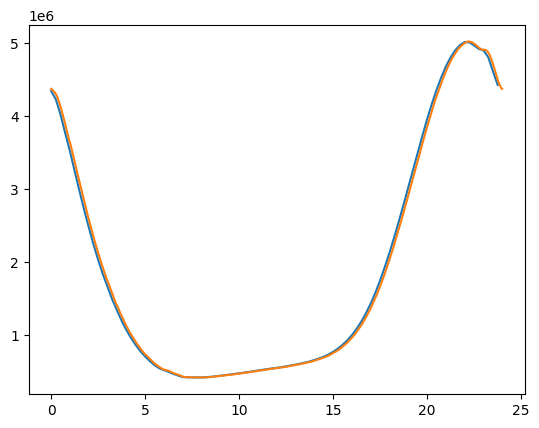

In [44]:
plt.plot(0.25*np.arange(0, 96), test_weekday_96['Residential L2'])
plt.plot((1/60)*np.arange(0, 1440), test_weekday['Residential L2'])

In [47]:
def min_60_to_15(test_weekday):
    
    test_weekday_96 = pd.DataFrame(np.zeros((96, 6)), columns=test_weekday.columns)
    for i in range(96):
        inds = np.arange(15*i, 15*(i+1))
        for col in test_weekday.columns:
            test_weekday_96.loc[i, col] = (1/15)*test_weekday.loc[inds, col].sum()
    
    return test_weekday_96

In [48]:
control_cases_dict = {'weekday':[case+'_weekday_'+year for case in ['AEF', 'MEF'] for year in ['2023', '2028', '2033']],
                      'weekend':[case+'_weekend_'+year for case in ['AEF', 'MEF'] for year in ['2023', '2028', '2033']]}


In [50]:
save_date = '20240208'
date = '20240208'
profile_column = {'home':'Residential L2', 'work':'Workplace L2'}
ev_case_names = {'LowHome_HighWork_100p_NoTimers_':'LowHome_HighWork_100p', 'HighHome_100p_NoTimers_':'HighHome_100p', 'UniversalHome_100p_NoTimers_':'UniversalHome_100p'}
for ev_case in ev_cases:
    for weekday, control_cases in control_cases_dict.items():
        for control in control_cases:
            for reg in ['nonreg']:#, 'reg10']:
                print(ev_case, weekday, control, reg)
                if weekday == 'weekday':
                    test = pd.read_csv('../Data/'+ev_case+'WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                else:
                    test = pd.read_csv('../Data/'+ev_case+'weekend_WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                clf_home = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+'home'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_home = np.max(test3[profile_column['home']].values)
                controlled_home = normval_home * clf_home.predict((test3[profile_column['home']].values/normval_home).reshape(1, -1))
                test2[profile_column['home']] = controlled_home.ravel()
                clf_work = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+'work'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_work = np.max(test3[profile_column['work']].values)
                controlled_work = normval_work * clf_work.predict((test3[profile_column['work']].values/normval_work).reshape(1, -1))
                test2[profile_column['work']] = controlled_work.ravel()
                test2.to_csv('../Data/EVProfiles/'+'controlled_15min_'+control+'_'+ev_case_names[ev_case]+'_'+reg+'_'+save_date+'.csv')


LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2033 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2023 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2028 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2033 nonreg
HighHome_100p_NoTimers_ weekday MEF_weekday_2023 nonreg
HighHome

In [51]:
ev_cases

['LowHome_HighWork_100p_NoTimers_',
 'HighHome_100p_NoTimers_',
 'UniversalHome_100p_NoTimers_']

In [55]:
uncont_date = '20230731'

for ev_case in ['LowHome_HighWork', 'HighHome', 'UniversalHome']:#ev_cases:
    test = pd.read_csv('../Data/EVProfiles/uncontrolled_'+ev_case+'_100p_weekday_'+uncont_date+'.csv', index_col=0)
    test3 = min_60_to_15(test)
    test3.to_csv('../Data/EVProfiles/uncontrolled_15min_'+ev_case+'_100p_weekday_'+save_date+'.csv')
    test = pd.read_csv('../Data/EVProfiles/uncontrolled_'+ev_case+'_100p_weekend_'+uncont_date+'.csv', index_col=0)
    test3 = min_60_to_15(test)
    test3.to_csv('../Data/EVProfiles/uncontrolled_15min_'+ev_case+'_100p_weekend_'+save_date+'.csv')

In [86]:
#co2

control_cases_dict = {'weekday':[case+'_weekday_'+year for case in ['AEF', 'MEF'] for year in ['2023', '2028', '2033']],
                      'weekend':[case+'_weekend_'+year for case in ['AEF', 'MEF'] for year in ['2023', '2028', '2033']]}


profile_column = {'home':'Residential L2', 'work':'Workplace L2'}
ev_case_names = {'LowHome_HighWork_100p_NoTimers_':'LowHome_HighWork_100p', 'HighHome_100p_NoTimers_':'HighHome_100p', 'UniversalHome_100p_NoTimers_':'UniversalHome_100p'}
for ev_case in ev_cases:
    for weekday, control_cases in control_cases_dict.items():
        for control in control_cases:
            for reg in ['nonreg']:
                print(ev_case, weekday, control, reg)
                if weekday == 'weekday':
                    test = pd.read_csv('../Data/'+ev_case+'WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                else:
                    test = pd.read_csv('../Data/'+ev_case+'weekend_WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                clf_home = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+'home'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_home = np.max(test3[profile_column['home']].values)
                controlled_home = normval_home * clf_home.predict((test3[profile_column['home']].values/normval_home).reshape(1, -1))
                test2[profile_column['home']] = controlled_home.ravel()
                clf_work = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+'work'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_work = np.max(test3[profile_column['work']].values)
                controlled_work = normval_work * clf_work.predict((test3[profile_column['work']].values/normval_work).reshape(1, -1))
                test2[profile_column['work']] = controlled_work.ravel()
                test2.to_csv('../Data/EVProfiles/'+'controlled_15min_co2_'+control+'_'+ev_case_names[ev_case]+'_'+reg+'_'+save_date+'.csv')


LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekday AEF_weekday_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekday MEF_weekday_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekend AEF_weekend_2033 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2023 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2028 nonreg
LowHome_HighWork_100p_NoTimers_ weekend MEF_weekend_2033 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2023 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2028 nonreg
HighHome_100p_NoTimers_ weekday AEF_weekday_2033 nonreg
HighHome_100p_NoTimers_ weekday MEF_weekday_2023 nonreg
HighHome

In [62]:
control_cases_dict = {'weekday':['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_weekday' for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033']],
                      'weekend':['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_weekend' for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033']]}

profile_column = {'home':'Residential L2', 'work':'Workplace L2'}
ev_case_names = {'LowHome_HighWork_100p_NoTimers_':'LowHome_HighWork_100p', 'HighHome_100p_NoTimers_':'HighHome_100p', 'UniversalHome_100p_NoTimers_':'UniversalHome_100p'}
for ev_case in ev_cases:
    for weekday, control_cases in control_cases_dict.items():
        for control in control_cases:
            for reg in ['nonreg']:
                print(ev_case, weekday, control, reg)
                if weekday == 'weekday':
                    test = pd.read_csv('../Data/'+ev_case+'WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                else:
                    test = pd.read_csv('../Data/'+ev_case+'weekend_WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                clf_home = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+'home'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_home = np.max(test3[profile_column['home']].values)
                controlled_home = normval_home * clf_home.predict((test3[profile_column['home']].values/normval_home).reshape(1, -1))
                test2[profile_column['home']] = controlled_home.ravel()
                clf_work = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_'+'work'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_work = np.max(test3[profile_column['work']].values)
                controlled_work = normval_work * clf_work.predict((test3[profile_column['work']].values/normval_work).reshape(1, -1))
                test2[profile_column['work']] = controlled_work.ravel()
                test2.to_csv('../Data/EVProfiles/'+'controlled_15min_'+control+'_'+ev_case_names[ev_case]+'_'+reg+'_'+save_date+'.csv')


LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTi

In [68]:
control_cases_dict = {'weekday':['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_weekday' for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033']],
                      'weekend':['MRMEF_delta'+str(deltaMW)+'_startyear'+year+'_5yearsahead_weekend' for deltaMW in [5000, 10000] for year in ['2023', '2028', '2033']]}

profile_column = {'home':'Residential L2', 'work':'Workplace L2'}
ev_case_names = {'LowHome_HighWork_100p_NoTimers_':'LowHome_HighWork_100p', 'HighHome_100p_NoTimers_':'HighHome_100p', 'UniversalHome_100p_NoTimers_':'UniversalHome_100p'}
for ev_case in ev_cases:
    for weekday, control_cases in control_cases_dict.items():
        for control in control_cases:
            for reg in ['nonreg']:
                print(ev_case, weekday, control, reg)
                if weekday == 'weekday':
                    test = pd.read_csv('../Data/'+ev_case+'WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                else:
                    test = pd.read_csv('../Data/'+ev_case+'weekend_WECC_20220313.csv', index_col=0)
                    test3 = min_60_to_15(test)
                    test2 = test3.copy(deep=True)
                clf_home = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+'home'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_home = np.max(test3[profile_column['home']].values)
                controlled_home = normval_home * clf_home.predict((test3[profile_column['home']].values/normval_home).reshape(1, -1))
                test2[profile_column['home']] = controlled_home.ravel()
                clf_work = pickle.load(open('../Data/Control_Data_ModelObjects/ridgeregression_model_co2_'+'work'+'_'+control+'_'+reg+'_'+save_date+'.p', "rb"))
                normval_work = np.max(test3[profile_column['work']].values)
                controlled_work = normval_work * clf_work.predict((test3[profile_column['work']].values/normval_work).reshape(1, -1))
                test2[profile_column['work']] = controlled_work.ravel()
                test2.to_csv('../Data/EVProfiles/'+'controlled_15min_co2_'+control+'_'+ev_case_names[ev_case]+'_'+reg+'_'+save_date+'.csv')


LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2023_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2028_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta5000_startyear2033_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2023_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2028_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekday MRMEF_delta10000_startyear2033_5yearsahead_weekday nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2023_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2028_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta5000_startyear2033_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTimers_ weekend MRMEF_delta10000_startyear2023_5yearsahead_weekend nonreg
LowHome_HighWork_100p_NoTi

[0.92217176 0.95877856 1.        ]


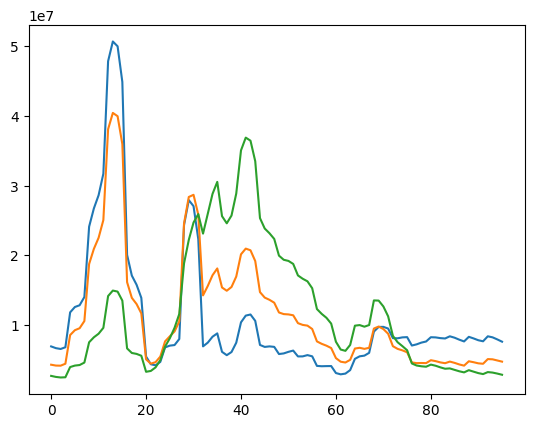

In [71]:
# tmp0 = pd.read_csv('Data/uncontrolled_UniversalHome_100p_weekday_20230731.csv', index_col=0)
# tmp0['Total'] = tmp0.sum(axis=1)
tmp1 = pd.read_csv('../Data/EVProfiles/controlled_15min_MRMEF_delta10000_startyear2023_5yearsahead_weekday_UniversalHome_100p_nonreg_20240208.csv', index_col=0)
tmp1['Total'] = tmp1.sum(axis=1)
tmp2 = pd.read_csv('../Data/EVProfiles/controlled_15min_MRMEF_delta10000_startyear2023_5yearsahead_weekday_HighHome_100p_nonreg_20240208.csv', index_col=0)
tmp2['Total'] = tmp2.sum(axis=1)
tmp3 = pd.read_csv('../Data/EVProfiles/controlled_15min_MRMEF_delta10000_startyear2023_5yearsahead_weekday_LowHome_HighWork_100p_nonreg_20240208.csv', index_col=0)
tmp3['Total'] = tmp3.sum(axis=1)

vals = [tmp['Total'].sum() for tmp in [tmp1, tmp2, tmp3]]
print(vals/np.max(vals))

# plt.plot(tmp0['Total'])
plt.plot(tmp1['Total'])
plt.plot(tmp2['Total'])
plt.plot(tmp3['Total'])
# plt.plot(tmp4['Total'])
plt.show()

[0.92118408 0.9578355  1.        ]


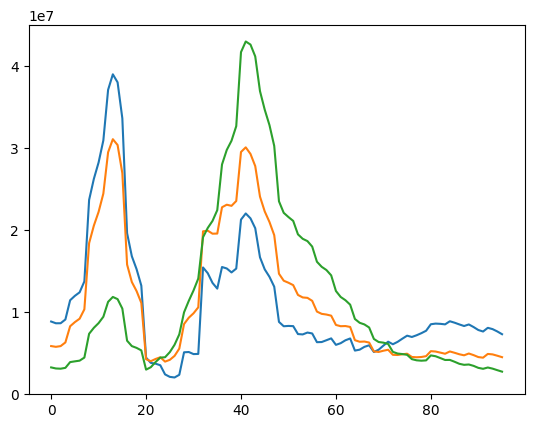

In [70]:
# tmp0 = pd.read_csv('Data/uncontrolled_UniversalHome_100p_weekday_20230731.csv', index_col=0)
# tmp0['Total'] = tmp0.sum(axis=1)
tmp1 = pd.read_csv('../Data/EVProfiles/controlled_15min_co2_MRMEF_delta10000_startyear2023_5yearsahead_weekday_UniversalHome_100p_nonreg_20240208.csv', index_col=0)
tmp1['Total'] = tmp1.sum(axis=1)
tmp2 = pd.read_csv('../Data/EVProfiles/controlled_15min_co2_MRMEF_delta10000_startyear2023_5yearsahead_weekday_HighHome_100p_nonreg_20240208.csv', index_col=0)
tmp2['Total'] = tmp2.sum(axis=1)
tmp3 = pd.read_csv('../Data/EVProfiles/controlled_15min_co2_MRMEF_delta10000_startyear2023_5yearsahead_weekday_LowHome_HighWork_100p_nonreg_20240208.csv', index_col=0)
tmp3['Total'] = tmp3.sum(axis=1)

vals = [tmp['Total'].sum() for tmp in [tmp1, tmp2, tmp3]]
print(vals/np.max(vals))

# plt.plot(tmp0['Total'])
plt.plot(tmp1['Total'])
plt.plot(tmp2['Total'])
plt.plot(tmp3['Total'])
# plt.plot(tmp4['Total'])
plt.show()

In [79]:
total_val = pd.DataFrame(index = ['HighHome', 'UniversalHome', 'LowHome_HighWork'], columns=[name+'_weekday_'+str(year) for name in ['AEF', 'MEF'] for year in [2023, 2028, 2033]])
for ev_case in ['HighHome', 'UniversalHome', 'LowHome_HighWork']:
    for control in [name+'_weekday_'+str(year) for name in ['AEF', 'MEF'] for year in [2023, 2028, 2033]]:
        total_val.loc[ev_case, control] = pd.read_csv('../Data/EVProfiles/controlled_15min_'+control+'_'+ev_case+'_100p_nonreg_'+date+'.csv').sum().sum()
        
    total_val.loc[ev_case, 'Uncontrolled'] = pd.read_csv('../Data/EVProfiles/uncontrolled_15min_'+ev_case+'_100p_weekday_'+date+'.csv').sum().sum()
    

In [80]:
for ev_case in ['HighHome', 'UniversalHome', 'LowHome_HighWork']:
    for control in ['MRMEF_delta'+str(deltaMW)+'_startyear'+str(year)+'_5yearsahead_weekday' for deltaMW in [5000, 10000] for year in [2023, 2028, 2033]]:
        total_val.loc[ev_case, control] = pd.read_csv('../Data/EVProfiles/controlled_15min_'+control+'_'+ev_case+'_100p_nonreg_'+date+'.csv').sum().sum()
        

In [81]:
total_val / total_val.max().max()

,AEF_weekday_2023,AEF_weekday_2028,AEF_weekday_2033,MEF_weekday_2023,MEF_weekday_2028,MEF_weekday_2033,Uncontrolled,MRMEF_delta5000_startyear2023_5yearsahead_weekday,MRMEF_delta5000_startyear2028_5yearsahead_weekday,MRMEF_delta5000_startyear2033_5yearsahead_weekday,MRMEF_delta10000_startyear2023_5yearsahead_weekday,MRMEF_delta10000_startyear2028_5yearsahead_weekday,MRMEF_delta10000_startyear2033_5yearsahead_weekday
HighHome,0.952199,0.95007,0.950369,0.951586,0.94921,0.952521,0.961926,0.949308,0.947836,0.948602,0.949373,0.947290,0.948379
UniversalHome,0.916396,0.91474,0.915113,0.915633,0.913215,0.917537,0.927481,0.912707,0.911629,0.912735,0.913125,0.910949,0.912458
LowHome_HighWork,0.993044,0.988152,0.988259,0.992825,0.989741,0.9901,1.000000,0.991523,0.987875,0.987508,0.990190,0.987673,0.987427


In [82]:
total_val.T / total_val.T.max()

,HighHome,UniversalHome,LowHome_HighWork
AEF_weekday_2023,0.989887,0.988049,0.993044
AEF_weekday_2028,0.987674,0.986263,0.988152
AEF_weekday_2033,0.987985,0.986665,0.988259
MEF_weekday_2023,0.98925,0.987226,0.992825
MEF_weekday_2028,0.98678,0.984619,0.989741
MEF_weekday_2033,0.990222,0.989279,0.9901
Uncontrolled,1.0,1.0,1.0
MRMEF_delta5000_startyear2023_5yearsahead_weekday,0.986882,0.984071,0.991523
MRMEF_delta5000_startyear2028_5yearsahead_weekday,0.985351,0.982908,0.987875
MRMEF_delta5000_startyear2033_5yearsahead_weekday,0.986148,0.984101,0.987508


# Errors

In [72]:
import pandas as pd
import numpy as np

In [73]:
date = '20240208'
df1 = pd.read_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_'+date+'.csv', index_col=0)
home_cols = [col for col in df1.columns if 'home' in col]
work_cols = [col for col in df1.columns if 'work' in col]
print('Home. min:', np.round(df1.loc['rmse', home_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', home_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', home_cols].mean(), 4))
print('Work. min:', np.round(df1.loc['rmse', work_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', work_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', work_cols].mean(), 4))


Home. min: 0.0389  max:  0.0554 mean:  0.0508
Work. min: 0.0283  max:  0.0375 mean:  0.0318


In [74]:
df1 = pd.read_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_mrmef_'+date+'.csv', index_col=0)
home_cols = [col for col in df1.columns if 'home' in col]
work_cols = [col for col in df1.columns if 'work' in col]
print('Home. min:', np.round(df1.loc['rmse', home_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', home_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', home_cols].mean(), 4))
print('Work. min:', np.round(df1.loc['rmse', work_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', work_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', work_cols].mean(), 4))


Home. min: 0.0541  max:  0.0769 mean:  0.0657
Work. min: 0.0207  max:  0.0392 mean:  0.0321


In [87]:
df1 = pd.read_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_co2_'+date+'.csv', index_col=0)
home_cols = [col for col in df1.columns if 'home' in col]
work_cols = [col for col in df1.columns if 'work' in col]
print('Home. min:', np.round(df1.loc['rmse', home_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', home_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', home_cols].mean(), 4))
print('Work. min:', np.round(df1.loc['rmse', work_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', work_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', work_cols].mean(), 4))


Home. min: 0.0501  max:  0.0655 mean:  0.0567
Work. min: 0.0151  max:  0.033 mean:  0.0271


In [76]:
df1 = pd.read_csv('../Data/Control_Data_ModelObjects/ridgeregression_errors_co2_mrmef_'+date+'.csv', index_col=0)
home_cols = [col for col in df1.columns if 'home' in col]
work_cols = [col for col in df1.columns if 'work' in col]
print('Home. min:', np.round(df1.loc['rmse', home_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', home_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', home_cols].mean(), 4))
print('Work. min:', np.round(df1.loc['rmse', work_cols].min(), 4), ' max: ',np.round(df1.loc['rmse', work_cols].max(), 4), 'mean: ',np.round(df1.loc['rmse', work_cols].mean(), 4))


Home. min: 0.0546  max:  0.0648 mean:  0.0616
Work. min: 0.0292  max:  0.0325 mean:  0.0305
